# Notebook for calculating correlations from .h5 files and average them

## Insert folder name containing the .h5 files to analyze. 

In [1]:
FolderName = r'.'

## Give a name for these data. 

In [2]:
name = r'measurement_1719588918.h5'

## What do you want to correlate?

### Possiblities are: 'donor', 'acceptor','cross'

In [3]:
Channel = 'donor'

## Loading standard things, do not change

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import optimize
from fretbursts import *
import pycorrelate as pyc
# plt.style.use('seaborn-talk')
import matplotlib.gridspec as gridspec

 - Optimized (cython) burst search loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.8.0.post0+g6b05a68.d20240601).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


## Find number .h5 of files in folder

In [5]:
for file in os.listdir(FolderName):
    if file.endswith('.h5'):
        FileList = [os.path.join(FolderName, f) for f in os.listdir(FolderName) if f.endswith('.h5')]

## Calculating the auto-correlations for each file and the average correlation

In [6]:
#Creating delay times in number of microtime units
time_bins = np.concatenate([[0], np.logspace(-5,0,20)])


for i, FileName in enumerate(FileList):
    data = loader.photon_hdf5(FileName)
    # extract the timestamps unit and create bins based on said uinit
    if i == 0:
        timestamps_unit = data.clk_p
        bins = (time_bins / timestamps_unit).astype(int)
        # in case any bins become identical due to integer conversion
        mask_diff = np.concatenate([[True], np.diff(bins) != 0])
        bins = bins[mask_diff]
        # setup rest of arrays
        G = np.zeros((len(bins)-1,len(FileList)))
        Brightness=np.zeros(len(FileList))
        Brightness_temp=np.zeros(len(FileList))

    #data.add(det_donor_accept = (2, 0), alex_period = 4000, offset = 0, D_ON = (2, 4000), A_ON = (0, 1))
    if data.alternated:
        loader.alex_apply_period(data)
    print(data.time_max*data.clk_p)
    if Channel == 'donor':
        FCS=data.get_ph_times(ph_sel=Ph_sel(Dex='Dem'))   # Time stamps donor excitation, donor emission
        Brightness[i]=np.size(FCS)/data.time_max
        G_temp = pyc.pcorrelate(FCS,FCS, bins, normalize=True)-1
        G[:,i]=G_temp
    elif Channel == 'acceptor':
        FCS=data.get_ph_times(ph_sel=Ph_sel(Dex='Aem'))   # Time stamps acceptor excitation, acceptor emission
        Brightness[index]=np.size(FCS)/data.time_max
        G_temp = pyc.pcorrelate(FCS,FCS, bins, normalize=True)-1
        G[:,i]=G_temp
    elif Channel == 'cross':
        FCS_donor=data.get_ph_times(ph_sel=Ph_sel(Dex='Dem'))   # Time stamps donor excitation, donor emission
        FCS_acceptor=data.get_ph_times(ph_sel=Ph_sel(Dex='Aem'))   # Time stamps acceptor excitation, acceptor emission
        Brightness[index]=np.size(FCS_donor)/data.time_max
        G_temp = pyc.pcorrelate(FCS_donor,FCS_acceptor, bins, normalize=True)-1
        G[:,i] = G_temp
        
averageFCS=np.mean(G,axis=1)
averageBrightness=np.mean(Brightness)

0.0002999999750000001


In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Brightness/1000,label='Average intensity')
plt.xlabel(r'Measurement #',fontsize=25)
plt.ylabel(r'Average intensity (kCnts/s)',fontsize=25)


plt.show()

In [ ]:
datasets=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14)

In [ ]:
averageFCS=np.mean(G[:,datasets],axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(np.mean([bins[1:], bins[:-1]], 0)*timestamps_unit,G[:,datasets],linewidth=1,label='Correlation')
ax.semilogx(np.mean([bins[1:], bins[:-1]], 0)*timestamps_unit,averageFCS,color='black',linewidth=3,label='Average correlation')

ax.set_xlabel(r'$\tau$ (s)',fontsize=25)
ax.set_ylabel(r'G',fontsize=25)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
#ax.set_xlim(0.01,1)
#ax.set_ylim(0,0.1)


#ax.legend()

plt.show()

In [ ]:
#Save the figure as a pdf
fig.savefig(name + ' raw data.pdf', dpi=300, bbox_inches = 'tight')

# Fitting correlation curves

In [ ]:
#Standard model, only considering diffusion
def FCS(t, Nmol, difftime, kappa):
    return (1/Nmol) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa**2)*difftime)))**(-0.5)

In [ ]:
#Extended model where a triplet fraction is included
def FCSTrip(t, N, difftime, kappa, Tfrac, triptime):
    return (1/N) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa**2)*difftime)))**(-0.5) * ((1 - Tfrac + Tfrac * np.exp(-(t/triptime))/(1-Tfrac)))

In [ ]:
#Fitting the average correlation curve
xdataFCS=np.mean([bins[1:], bins[:-1]], 0)*timestamps_unit

#We only use the diffusion with triplet
paramsFCS, params_covarianceFCS = optimize.curve_fit(FCSTrip, xdataFCS, averageFCS, p0=[np.round(1/averageFCS[0],2),75e-6,10,0.05,10e-6],method='lm')
print(paramsFCS)

print('Brightness =')
print(np.round(averageBrightness/paramsFCS[0]))

#Output format:
#Triplet [Number of particles in confocal volume, Diffusion time (s), Aspect ratio, Triplet fraction, Triplet time (ms)]

In [ ]:
figure1 = plt.figure(1, figsize=(10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.25], figure=figure1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.02, hspace=0)

#Plot the FCS data and fit
ax1 = plt.subplot(gs[0,0])
ax1.semilogx(xdataFCS, averageFCS, 'o', label='Average correlation',color='black')
ax1.semilogx(xdataFCS,FCSTrip(xdataFCS, paramsFCS[0], paramsFCS[1],paramsFCS[2], paramsFCS[3], paramsFCS[4]),
         label='Pure diffusion + Triplet',color='red')

ax1.set_ylabel(r'G',fontsize=25)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_xlabel(r' ') # Force this empty !
ax1.set_xticklabels([]) # Force this empty !
ax1.get_yaxis().set_label_coords(-0.12,0.5)


ax1.text(10**(-2.75), 0.75*averageFCS[0], r'B = '+str(np.round(0.001*averageBrightness/paramsFCS[0],1))+' kCnts s$^-$$^1$ mol$^-$$^1$', fontsize=15)
ax1.text(10**(-2.75), 0.68*averageFCS[0], r'N = '+ str(np.round(paramsFCS[0],1)), fontsize=15)
ax1.text(10**(-2.75), 0.61*averageFCS[0], r'$\kappa$ = '+ str(np.round(np.absolute(paramsFCS[2]),1)), fontsize=15)
ax1.text(10**(-2.75), 0.54*averageFCS[0], r'$\tau$$_D$ = '+ str(np.round(paramsFCS[1]*10**6,1))+' $\mu$s', fontsize=15)
ax1.text(10**(-2.75), 0.47*averageFCS[0], r'T = '+ str(np.round(paramsFCS[3],2)), fontsize=15)

ax1.set_title(name)
ax1.legend()


#Plot the residuals
ax2= plt.subplot(gs[1,0])
ax2.semilogx(xdataFCS,(FCSTrip(xdataFCS, paramsFCS[0], paramsFCS[1],paramsFCS[2], paramsFCS[3], paramsFCS[4])-averageFCS),
         label='Pure diffusion + Triplet',color='Red')

ax2.set_xlabel(r'$\tau$ (s)',fontsize=25)
ax2.set_ylabel(r'Residuals',fontsize=25)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.get_yaxis().set_label_coords(-0.12,0.5)


plt.show()

In [ ]:
#Save the figure as a pdf
figure1.savefig(name + '.pdf',dpi=300, bbox_inches = 'tight')

# SPECIAL: Fitting with structural parameter fixed

In [7]:
kappa_fixed = 10

In [8]:
#Standard model, only considering diffusion
def FCSfixed(t, Nmol, difftime):
    return (1/Nmol) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa_fixed**2)*difftime)))**(-0.5)

In [9]:
#Extended model where a triplet fraction is included
def FCSTripfixed(t, N, difftime, Tfrac, triptime):
    return (1/N) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa_fixed**2)*difftime)))**(-0.5) * ((1 - Tfrac + Tfrac * np.exp(-(t/triptime))/(1-Tfrac)))

In [10]:
#Fitting the average correlation curve
xdataFCS=np.mean([bins[1:], bins[:-1]], 0)*timestamps_unit

#We only use the diffusion with triplet
paramsFCSfixed, params_covarianceFCSfixed = optimize.curve_fit(FCSTripfixed, xdataFCS, averageFCS, p0=[np.round(1/averageFCS[0],2),100e-6,0.1,10e-6],method='lm')
print(paramsFCSfixed)

print('Brightness =')
print(np.round(averageBrightness/paramsFCSfixed[0]))

#Output format:
#Triplet [Number of particles in confocal volume, Diffusion time (s), Aspect ratio, Triplet fraction, Triplet time (ms)]

/tmp/ipykernel_38721/3339592454.py:3: RuntimeWarning: overflow encountered in exp
  return (1/N) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa_fixed**2)*difftime)))**(-0.5) * ((1 - Tfrac + Tfrac * np.exp(-(t/triptime))/(1-Tfrac)))


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

NameError: name 'paramsFCSfixed' is not defined

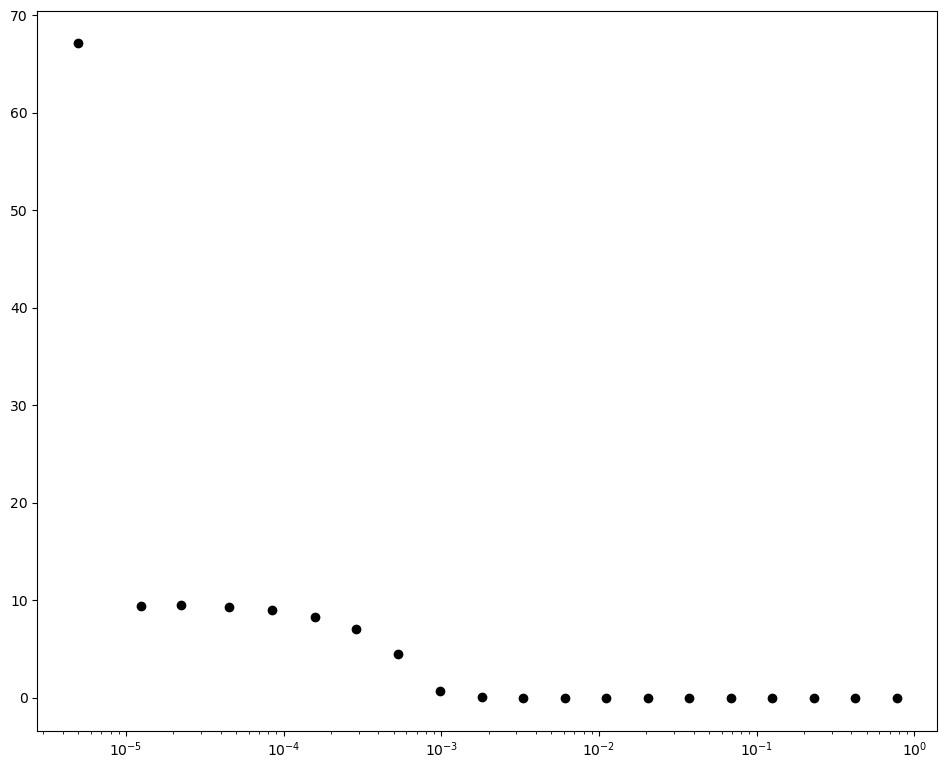

In [11]:
figure2 = plt.figure(1, figsize=(10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.25], figure=figure2)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.02, hspace=0)

#Plot the FCS data and fit
ax1 = plt.subplot(gs[0,0])
ax1.semilogx(xdataFCS, averageFCS, 'o', label='Average correlation',color='black')
ax1.semilogx(xdataFCS,FCSTripfixed(xdataFCS, paramsFCSfixed[0], paramsFCSfixed[1],paramsFCSfixed[2], paramsFCSfixed[3]),
         label='Pure diffusion + Triplet, $\kappa$ is fixed',color='blue')

ax1.set_ylabel(r'G',fontsize=25)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_xlabel(r' ') # Force this empty !
ax1.set_xticklabels([]) # Force this empty !
ax1.get_yaxis().set_label_coords(-0.12,0.5)

#Add parameters to plot
ax1.text(10**(-2.75), 0.75*averageFCS[0], r'B = '+str(np.round(0.001*averageBrightness/paramsFCSfixed[0]))+' kCnts s$^-$$^1$ mol$^-$$^1$', fontsize=15)
ax1.text(10**(-2.75), 0.68*averageFCS[0], r'N = '+ str(np.round(paramsFCSfixed[0],1)), fontsize=15)
ax1.text(10**(-2.75), 0.61*averageFCS[0], r'$\kappa$ = '+ str(kappa_fixed)+' (fixed)', fontsize=15)
ax1.text(10**(-2.75), 0.54*averageFCS[0], r'$\tau$$_D$ = '+ str(np.round(paramsFCSfixed[1]*10**6,1))+' $\mu$s', fontsize=15)
ax1.text(10**(-2.75), 0.47*averageFCS[0], r'T = '+ str(np.round(paramsFCSfixed[2],2)), fontsize=15)

ax1.set_title(name)
ax1.legend()


#Plot the residuals
ax2= plt.subplot(gs[1,0])
ax2.semilogx(xdataFCS,FCSTripfixed(xdataFCS, paramsFCSfixed[0], paramsFCSfixed[1],paramsFCSfixed[2], paramsFCSfixed[3])-averageFCS,
         label=r'Pure diffusion + Triplet fixed $\kappa$',color='blue')


ax2.set_xlabel(r'$\tau$ (s)',fontsize=25)
ax2.set_ylabel(r'Residuals',fontsize=25)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.get_yaxis().set_label_coords(-0.12,0.5)


plt.show()

In [226]:
#Save the figure as a pdf
figure2.savefig(name + ' kappa fixed.pdf',dpi=300, bbox_inches = 'tight')